In [13]:
import pickle
import json
import numpy as np
from itertools import groupby
import cv2
from matplotlib import pyplot as plt

In [2]:
anno_pth = '/home/ubuntu/data/nuScenes_small/annotations/{}.json'.format('val')
    
with open(anno_pth) as f:
    nusc = json.load(f)

In [4]:
pred_path = '/home/ubuntu/visualDet3D/visualDet3D/workspace/Mono3D_nuscenes_threading/output/validation/data/submission.json'

with open(pred_path) as f:
    preds = json.load(f)['results']
    

In [4]:
preds['6']

[{'sample_token': 6,
  'translation': [6.221279621124268, 1.7289612591266632, 16.123876571655273],
  'size': [0.7851811051368713, 0.5096220374107361, 1.5800498723983765],
  'rotation': 3.220593214035034,
  'alpha': 2.8523507118225098,
  'velocity': 0.0,
  'num_pts': -1,
  'detection_name': 'bicycle',
  'detection_score': 0.611165463924408,
  'attribute_name': ''},
 {'sample_token': 6,
  'translation': [14.714482307434082, 0.43181920051574707, 31.23771095275879],
  'size': [1.6579673290252686, 0.7073101997375488, 0.6771550178527832],
  'rotation': 4.453525066375732,
  'alpha': 4.0133056640625,
  'velocity': 0.0,
  'num_pts': -1,
  'detection_name': 'pedestrian',
  'detection_score': 0.5469103455543518,
  'attribute_name': ''},
 {'sample_token': 6,
  'translation': [5.066816806793213, 1.5026441812515259, 13.422212600708008],
  'size': [1.1508171558380127, 0.5799700617790222, 1.8191112279891968],
  'rotation': 3.0505309104919434,
  'alpha': 2.689574718475342,
  'velocity': 0.0,
  'num_pts

In [4]:
nusc.keys()

dict_keys(['images', 'annotations', 'categories', 'videos', 'attributes'])

In [5]:
nusc['categories'] = {cate['id']: cate['name'] for cate in nusc['categories']}
nusc['categories']

{1: 'car',
 2: 'truck',
 3: 'bus',
 4: 'trailer',
 5: 'construction_vehicle',
 6: 'pedestrian',
 7: 'motorcycle',
 8: 'bicycle',
 9: 'traffic_cone',
 10: 'barrier'}

In [6]:
nusc['annotations'] = sorted(nusc['annotations'], key=lambda k: k['image_id'])
sample_data = [[k, list(v)]for k, v in groupby(nusc['annotations'], lambda k: k['image_id'])]


In [7]:
nusc['images'] = {img['id']: img for img in nusc['images']}

In [8]:
nusc['images'][6]

{'id': 6,
 'file_name': 'samples/CAM_FRONT_LEFT/n015-2018-08-02-17-16-37+0800__CAM_FRONT_LEFT__1533201470404874.jpg',
 'calib': [[1272.597900390625, 0.0, 826.615478515625, 0.0],
  [0.0, 1272.597900390625, 479.75164794921875, 0.0],
  [0.0, 0.0, 1.0, 0.0]],
 'video_id': 1,
 'frame_id': 1,
 'sensor_id': 6,
 'sample_token': 'fd8420396768425eabec9bdddf7e64b6',
 'trans_matrix': [[0.7529595066367342,
   -0.005928871165290648,
   0.658040143039975,
   251.47903037027174],
  [-0.6580507895080103,
   -0.013770192801157264,
   0.7528476208490682,
   917.9008508960982],
  [0.004597803089451863,
   -0.9998876088225734,
   -0.014269895929062856,
   1.4942467789991023],
  [0.0, 0.0, 0.0, 1.0]],
 'width': 1600,
 'height': 900,
 'pose_record_trans': [249.9010710170623, 917.551270026704, 0.0],
 'pose_record_rot': [0.9984418312826709,
  -0.008654774439473843,
  0.0024989952571667228,
  -0.05507049524938595],
 'cs_record_trans': [1.52387798135, 0.494631336551, 1.50932822144],
 'cs_record_rot': [0.67572650

In [9]:

def view_points(points: np.ndarray, view: np.ndarray, normalize: bool=True) -> np.ndarray:
    assert view.shape[0] <= 4
    assert view.shape[1] <= 4
    assert points.shape[0] == 3

    viewpad = np.eye(4)
    viewpad[:view.shape[0], :view.shape[1]] = view

    nbr_points = points.shape[1]

    # Do operation in homogenous coordinates.
    points = np.concatenate((points, np.ones((1, nbr_points))))
    points = np.dot(viewpad, points)
    points = points[:3, :]

    if normalize:
        points = points / points[2:3, :].repeat(3, 0).reshape(3, nbr_points)

    return points

def draw_box_3d(image, corners, c=(0, 0, 255)):
    face_idx = [[0,1,5,4],
              [1,2,6, 5],
              [2,3,7,6],
              [3,0,4,7]]
    for ind_f in range(3, -1, -1):
        f = face_idx[ind_f]
        for j in range(4):
            cv2.line(
                image, 
                (int(corners[f[j], 0]), int(corners[f[j], 1])),
                (int(corners[f[(j+1)%4], 0]), int(corners[f[(j+1)%4], 1])), 
                c, 2, lineType=cv2.LINE_AA
            )
        if ind_f == 0:
            cv2.line(image, (int(corners[f[0], 0]), int(corners[f[0], 1])),
                   (int(corners[f[2], 0]), int(corners[f[2], 1])), c, 1, lineType=cv2.LINE_AA)
            cv2.line(image, (int(corners[f[1], 0]), int(corners[f[1], 1])),
                   (int(corners[f[3], 0]), int(corners[f[3], 1])), c, 1, lineType=cv2.LINE_AA)

    return image

In [10]:

def computer_3d_corners(anno):
    dim = anno['size']
    location = anno['translation']
    rotation_y = anno['rotation']
    
#     dim = anno['dim']
#     location = anno['location']
#     rotation_y = anno['rotation_y']
#     alpha = anno['alpha']
    
    
#     print(dim)
#     print(location)
#     print(rotation_y)
#     print()
    
#     rotation_y = 0.
    c, s = np.cos(rotation_y), np.sin(rotation_y)
    R = np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]], dtype=np.float32)
    l, w, h = dim[2], dim[1], dim[0]

    # 3D bounding box corners. (Convention: x points forward, y to the left, zs up.)
#     x_corners = l / 2 * np.array([1,  1,  1,  1, -1, -1, -1, -1])
#     y_corners = w / 2 * np.array([1, -1, -1,  1,  1, -1, -1,  1])
#     z_corners = h / 2 * np.array([1,  1, -1, -1,  1,  1, -1, -1])
    
    x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
    y_corners = [0,0,0,0,-h,-h,-h,-h]
    z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]
    
    corners = np.vstack((x_corners, y_corners, z_corners))
    
    
    # Rotate
    corners = np.dot(R, corners)
    
    
    # Translate
    x, y, z = location
#     x, y, z = -7., 1.5, 16.
    corners[0, :] = corners[0, :] + x
    corners[1, :] = corners[1, :] + y
    corners[2, :] = corners[2, :] + z
    

        
    return corners


def render_image(img_id, anno_datas, image, calib):
    for anno in anno_datas:
        if anno['detection_score'] < 0.7: continue
#         print(anno['category_id'], nusc['categories'][anno['category_id']])
        corners = computer_3d_corners(anno)
        points = view_points(corners, calib)
        image = draw_box_3d(image, points.T)
#         break
    plt.imshow(image)
    plt.imsave(f'img_{img_id}.png', image)
    
        
        

def render_sample(img_id, anno_datas):
#     trans_matrix = np.array(nusc['images'][img_id]['trans_matrix'])
    calib = np.array(nusc['images'][img_id]['calib'])
    file_name = nusc['images'][img_id]['file_name']
    print(calib)
    image = cv2.imread('/home/ubuntu/data/nuScenes_small/nuscenes_small/' + file_name)
    render_image(img_id, anno_datas, image, calib)
    

[[1.26641724e+03 0.00000000e+00 8.16267029e+02 0.00000000e+00]
 [0.00000000e+00 1.26641724e+03 4.91507080e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]


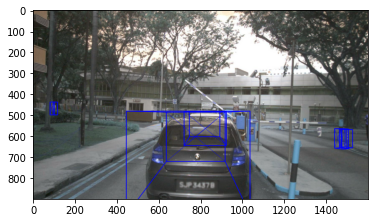

In [11]:
img_id = 1
anno_datas = preds[str(img_id)]
render_sample(img_id, anno_datas)


In [12]:
for anno in anno_datas:
    if anno['detection_score'] >= 0.7:
        print(anno)

{'sample_token': 1, 'translation': [-0.23079439997673035, 1.4195287823677063, 5.777184009552002], 'size': [1.4502562284469604, 1.7360024452209473, 4.112589359283447], 'rotation': -1.5756014585494995, 'velocity': 0.0, 'ego_translation': [0.0, 0.0, 0.0], 'num_pts': -1, 'detection_name': 'car', 'detection_score': 0.9528646469116211, 'attribute_name': ''}
{'sample_token': 1, 'translation': [8.148049354553223, 2.0793062448501587, 15.708824157714844], 'size': [1.1551718711853027, 0.4856031537055969, 0.5286895632743835], 'rotation': 4.388332843780518, 'velocity': 0.0, 'ego_translation': [0.0, 0.0, 0.0], 'num_pts': -1, 'detection_name': 'traffic_cone', 'detection_score': 0.8156625628471375, 'attribute_name': ''}
{'sample_token': 1, 'translation': [-19.38189125061035, 0.22202306985855103, 34.248172760009766], 'size': [1.6606125831604004, 0.6594798564910889, 0.5978073477745056], 'rotation': 2.0330982208251953, 'velocity': 0.0, 'ego_translation': [0.0, 0.0, 0.0], 'num_pts': -1, 'detection_name': 

In [15]:

for img_id in range (1, 11):
#     img_id = 10
    anno_datas = preds[str(img_id)]
    render_sample(img_id, anno_datas)

[[1.26641724e+03 0.00000000e+00 8.16267029e+02 0.00000000e+00]
 [0.00000000e+00 1.26641724e+03 4.91507080e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
[[1.26084741e+03 0.00000000e+00 8.07968262e+02 0.00000000e+00]
 [0.00000000e+00 1.26084741e+03 4.95334412e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
[[1.25951379e+03 0.00000000e+00 8.07252930e+02 0.00000000e+00]
 [0.00000000e+00 1.25951379e+03 5.01195801e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
[[809.2210083    0.         829.21960449   0.        ]
 [  0.         809.2210083  481.77841187   0.        ]
 [  0.           0.           1.           0.        ]]
[[1.25674146e+03 0.00000000e+00 7.92112549e+02 0.00000000e+00]
 [0.00000000e+00 1.25674146e+03 4.92775757e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
[[1.27259790e+03 0.00000000e+00 8.26615479e+02 0.00000000e+00]
 [0.0000000

In [151]:

for i, (image_id, anno_data) in enumerate(sample_data):
#     print(image_id)
#     for anno in anno_data:
#         print(anno)
    
    pass

print(i)

29312


In [24]:
nusc['images'][2]

{'id': 13,
 'file_name': 'samples/CAM_FRONT/n015-2018-07-18-11-07-57+0800__CAM_FRONT__1531883531412477.jpg',
 'calib': [[1266.417236328125, 0.0, 816.2670288085938, 0.0],
  [0.0, 1266.417236328125, 491.507080078125, 0.0],
  [0.0, 0.0, 1.0, 0.0]],
 'video_id': 1,
 'frame_id': 3,
 'sensor_id': 1,
 'sample_token': 'ae4e0c3aa3f24c91aab599e8b54e9264',
 'trans_matrix': [[0.9776651594026544,
   0.00013906976188756545,
   -0.21016854367336787,
   1009.7008529133224],
  [0.21014120218938695,
   0.015496483371367175,
   0.9775482259947693,
   616.3383990849011],
  [0.003392820741241521,
   -0.9998799126208722,
   0.015121147598497059,
   1.5459230541497808],
  [0.0, 0.0, 0.0, 1.0]],
 'width': 1600,
 'height': 900,
 'pose_record_trans': [1010.0616806220463, 614.708717153934, 0.0],
 'pose_record_rot': [-0.6305906420917541,
  -0.007283595672498927,
  0.00750974026770209,
  -0.776045098651812],
 'cs_record_trans': [1.70079118954, 0.0159456324149, 1.51095763913],
 'cs_record_rot': [0.4998015430569128,

In [34]:
nusc['annotations'][14]

{'id': 15,
 'image_id': 10,
 'category_id': 1,
 'dim': [1.44, 1.638, 4.25],
 'location': [-11.048985598859634, 1.5701773373617844, 7.851058440822949],
 'depth': 7.851058440822949,
 'occluded': 0,
 'truncated': 0,
 'rotation_y': 3.110337451821189,
 'iscrowd': 0,
 'track_id': 2,
 'attributes': 6,
 'velocity': [-6.006018419840262,
  0.07968302024571544,
  0.2859748788392306,
  0.0],
 'bbox': [0, 492.2254172278597, 0.962182948290097, 173.84534189155409],
 'area': 167.27102360771542,
 'alpha': 4.063350186235833,
 'keypoints': [-698.0609130859375,
  664.18017578125,
  0.0,
  -412.2337951660156,
  629.4691162109375,
  0.0,
  0.1246495395898819,
  627.2238159179688,
  2.0,
  -185.2531280517578,
  660.7676391601562,
  0.0,
  -698.0609130859375,
  496.9006042480469,
  0.0,
  -412.2337951660156,
  494.02288818359375,
  0.0,
  0.1246495395898819,
  493.8367004394531,
  2.0,
  -185.2531280517578,
  496.6177062988281,
  0.0,
  -309.6167907714844,
  569.4075317382812,
  0.0],
 'num_keypoints': 2.0}